In [88]:
import pandas as pd 
import numpy as np 
import matplotlib.pylab as plt 
import os 
path = os.getcwd()
print(path)

/Users/dang/Desktop/Learning/Mygit/datascience_supplychain_practice/Jupyternotebook_source/Section_12_forcasting_segmentation


In [89]:
retail = pd.read_csv("{0}/twentyeleven.csv".format(path))

In [90]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484330 entries, 0 to 484329
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      484329 non-null  float64
 1   StockCode    484330 non-null  object 
 2   Description  484330 non-null  object 
 3   Quantity     484330 non-null  int64  
 4   InvoiceDate  484330 non-null  object 
 5   Price        484330 non-null  float64
 6   Customer ID  367058 non-null  float64
 7   Country      484330 non-null  object 
 8   date         484330 non-null  object 
 9   revenue      484330 non-null  float64
 10  year         484330 non-null  int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 40.6+ MB


In [91]:
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])

In [92]:
retail['daysofweek'] = retail['InvoiceDate'].dt.dayofweek

In [93]:
retail['daysofweek'].value_counts()

3    92832
1    92491
0    84860
2    84439
4    71849
6    57859
Name: daysofweek, dtype: int64

In [94]:
retail['date'] = retail['InvoiceDate'].dt.strftime("%Y-%m-%d")
retail['date'] = pd.to_datetime(retail['date'])

In [95]:
#CV2

In [96]:
retail_grouped = retail.groupby(['Description', 'date']).agg(total_sales=('Quantity', 'sum')).reset_index()

In [97]:
cv_data = retail_grouped.groupby(['Description']).agg(average=('total_sales', 'mean'), sd=('total_sales', 'std')).reset_index()

In [98]:
cv_data['cv_squared'] = (cv_data['sd']/ cv_data['average'])**2

In [99]:
cv_data['cv_squared'].value_counts()

0.000000     125
0.222222      17
0.500000      17
0.187500      14
0.138889       9
            ... 
2.055254       1
1.163720       1
18.689153      1
2.251683       1
5.700494       1
Name: cv_squared, Length: 3464, dtype: int64

In [100]:
# ADI Average Demand Interval

In [101]:
product_by_date = retail.groupby(['Description', 'date']).agg(count=('Description', 'count')).reset_index()

In [102]:
retail = retail[['Description','date']].drop_duplicates()

In [103]:
skus = product_by_date.Description.unique()

In [104]:
empty_dataframe = pd.DataFrame()

In [105]:
for sku in skus:
    a = product_by_date[product_by_date.Description == sku]
    a['previous_date'] = a['date'].shift(1)
    empty_dataframe = pd.concat([empty_dataframe, a], axis=0)

ipykernel_launcher:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [130]:
empty_dataframe['Duration'] = empty_dataframe['date'] - empty_dataframe['previous_date']

In [133]:
empty_dataframe['duration']= empty_dataframe['Duration'].astype('string').str.replace(' days','')


In [135]:
empty_dataframe['duration'] = pd.to_numeric(empty_dataframe['Duration'], errors='coerce')

In [136]:
ADI = empty_dataframe.groupby('Description').agg(ADI=('duration', 'mean')).reset_index()

In [134]:
empty_dataframe

,Description,date,count,previous_date,Duration,duration
0,10 COLOUR SPACEBOY PEN,2011-01-05,1,NaT,NaT,NaT
1,10 COLOUR SPACEBOY PEN,2011-01-06,3,2011-01-05,1 days,1
2,10 COLOUR SPACEBOY PEN,2011-01-09,3,2011-01-06,3 days,3
3,10 COLOUR SPACEBOY PEN,2011-01-11,1,2011-01-09,2 days,2
4,10 COLOUR SPACEBOY PEN,2011-01-13,2,2011-01-11,2 days,2
...,...,...,...,...,...,...
255715,wrongly coded 20713,2011-10-06,1,NaT,NaT,NaT
255716,wrongly coded 23343,2011-10-27,1,NaT,NaT,NaT
255717,wrongly marked,2011-10-31,1,NaT,NaT,NaT
255718,wrongly marked 23343,2011-10-24,1,NaT,NaT,NaT


In [137]:
adi_cv= pd.merge(ADI, cv_data)

In [138]:
adi_cv

,Description,ADI,average,sd,cv_squared
0,10 COLOUR SPACEBOY PEN,-55386559258161304,36.030120,46.870217,1.692242
1,12 COLOURED PARTY BALLOONS,-79955304668302400,18.017391,16.152770,0.803730
2,12 DAISY PEGS IN WOOD BOX,-153319667280912928,5.533333,6.379168,1.329090
3,12 EGG HOUSE PAINTED WOOD,-124247859957496976,1.864865,1.306719,0.490987
4,12 HANGING EGGS HAND PAINTED,-1536911872809129216,6.666667,3.669696,0.303000
...,...,...,...,...,...
3955,wrongly coded 20713,-9223372036854775808,800.000000,NaN,NaN
3956,wrongly coded 23343,-9223372036854775808,1000.000000,NaN,NaN
3957,wrongly marked,-9223372036854775808,48.000000,NaN,NaN
3958,wrongly marked 23343,-9223372036854775808,200.000000,NaN,NaN


In [139]:
def category(dataframe):
    a = 0

    if((dataframe['ADI'] < 1.32) & (dataframe['cv_squared'] < 0.49)):
        a = 'smooth'
    if((dataframe['ADI'] >= 1.32) & (dataframe['cv_squared'] >= 0.49)):
        a = 'lumpy'
    if((dataframe['ADI'] < 1.32) & (dataframe['cv_squared'] >= 0.49)):
        a = 'erratic'
    if((dataframe['ADI'] >= 1.32) & (dataframe['cv_squared'] < 0.49)):
        a='intermittent'
    return a

In [112]:
adi_cv.head()

,Description,ADI,average,sd,cv_squared
0,10 COLOUR SPACEBOY PEN,NaN,36.030120,46.870217,1.692242
1,12 COLOURED PARTY BALLOONS,NaN,18.017391,16.152770,0.803730
2,12 DAISY PEGS IN WOOD BOX,NaN,5.533333,6.379168,1.329090
3,12 EGG HOUSE PAINTED WOOD,NaN,1.864865,1.306719,0.490987
4,12 HANGING EGGS HAND PAINTED,NaN,6.666667,3.669696,0.303000


In [140]:
adi_cv['category'] = adi_cv.apply(category, axis=1)

In [141]:
adi_cv.head()

,Description,ADI,average,sd,cv_squared,category
0,10 COLOUR SPACEBOY PEN,-55386559258161304,36.030120,46.870217,1.692242,erratic
1,12 COLOURED PARTY BALLOONS,-79955304668302400,18.017391,16.152770,0.803730,erratic
2,12 DAISY PEGS IN WOOD BOX,-153319667280912928,5.533333,6.379168,1.329090,erratic
3,12 EGG HOUSE PAINTED WOOD,-124247859957496976,1.864865,1.306719,0.490987,erratic
4,12 HANGING EGGS HAND PAINTED,-1536911872809129216,6.666667,3.669696,0.303000,smooth


In [142]:
adi_cv['category']

0       erratic
1       erratic
2       erratic
3       erratic
4        smooth
         ...   
3955          0
3956          0
3957          0
3958          0
3959          0
Name: category, Length: 3960, dtype: object

In [143]:

adi_cv.category.value_counts()


erratic    3178
smooth      586
0           196
Name: category, dtype: int64

,Description,ADI,average,sd,cv_squared,category
0,10 COLOUR SPACEBOY PEN,-55386559258161304,36.030120,46.870217,1.692242,erratic
1,12 COLOURED PARTY BALLOONS,-79955304668302400,18.017391,16.152770,0.803730,erratic
2,12 DAISY PEGS IN WOOD BOX,-153319667280912928,5.533333,6.379168,1.329090,erratic
3,12 EGG HOUSE PAINTED WOOD,-124247859957496976,1.864865,1.306719,0.490987,erratic
4,12 HANGING EGGS HAND PAINTED,-1536911872809129216,6.666667,3.669696,0.303000,smooth
...,...,...,...,...,...,...
3931,amazon,-2303747809213693952,16.500000,20.404248,1.529232,erratic
3934,check,-658565431203912576,86.928571,77.297093,0.790681,erratic
3938,dotcom,-2302819009213693952,17.750000,9.535023,0.288567,smooth
3942,found,-417952110766126144,90.454545,129.034778,2.034945,erratic


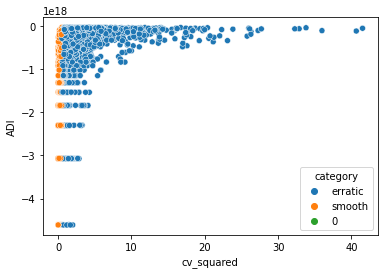

In [144]:
import seaborn as sns

sns.scatterplot(x='cv_squared',y='ADI',hue='category',data=adi_cv)

adi_cv[adi_cv.category!=0]
